# BSM定价模型的两个基本问题与python实现
在我们的定义中，定量分析是数学或统计学方法在市场数据上的应用。  ——John Forman

BSM定价模型的两个基本问题：
1. 隐含波动率  
以某些到期日的期权报价倒推出这些期权的隐含波动率，并汇出图表——这是期权交易者和风险管理者每天都要面对的任务。  
2. 蒙特卡洛模拟  
欧式期权价值的计算。通过蒙特卡罗技术，模拟股票在一段时间中变化。  

像Black-Scholes-Merton(1973)这样有深远影响的期权定价公式中，隐含波动率是在其他条件不变的情况下输入公式，得出不同期权行权价格和到期日测得市场报价的那些波动率值。

**BSM公式（1-1）**

\begin{align*}
 C(S_t,K,t,T,r)&=S_t\cdot N(d_1)-e^{-r(T-t)} \cdot K\cdot N(d_2)\\
 N(d)&=\frac{1}{\sqrt{2\pi}}\int_{-\infty}^{d}{e^{-1/2}x^2}dx\\
 d_1&=\frac{log(s_T/K)+(r+\sigma^2/2)(T-t)}{\sigma\sqrt{T-t}}\\
 d_2&=\frac{log(s_T/K)+(r-\sigma^2/2)(T-t)}{\sigma\sqrt{T-t}}
\end{align*}

不同参数有如下含义：  
$S_t$ 在时点t的标的物价格水平；  
$\sigma$ 标的物固定波动率（也就是收益的标准差）；  
$K$ 期权行权价格；    
$T$ 期权到期日；  
$r$ 固定无风险短期利率；  

现在考虑欧式看涨期权的一个报价$C^*$已知的情况。隐含波动率$\sigma^{imp}$是公式（1-1）中的隐式方程的解。  
**公式（1-2）** 方程式数值化求根的牛顿迭代法  
$$\sigma_{n+1}^{imp}=\sigma_n^{imp}-\frac{C(\sigma_n^{imp})-C^*}{\partial C(\sigma_n^{imp})/\partial \sigma_n^{imp}}$$  
  
期权定价公式对于波动率的偏微分称作Vega，公式1-3给出了Vega的闭合方式。  
公式1-3 BSM模型中欧式期权的Vega
$$\frac{\partial C}{\partial \sigma}=S_tN(d_1)\sqrt{T-t}$$

# 1. Black-Scholes-Merton python计算公式

In [14]:

import numpy as np
from math import sqrt, log
from scipy import stats
#
# 欧式期权BSM定价公式
def bsm_call_value(S0, K, T, r, sigma):
    """
    Parameters:
    ==========
    S0: float
        标的物初始价格水平
    K: float
       行权价格
    T: float
       到期日
    r: float
       固定无风险短期利率
    sigma: float
       波动因子
       
    Returns
    ==========
    value: float
    """
    S0 = float(S0)
    d1 = (np.log(S0 /K) + (r + 0.5 * sigma**2) * T )/(sigma * np.sqrt(T))
    d2 = (np.log(S0 /K) + (r - 0.5 * sigma**2) * T )/(sigma * np.sqrt(T))
    value = (S0 * stats.norm.cdf(d1, 0, 1) - K * np.exp(-r * T) * stats.norm.cdf(d2, 0, 1))
    return value
    
def bsm_vega(S0, K, T, r, sigma):
    """
    Vega 计算
    """
    S0 = float(S0)
    d1 = (np.log(S0/K)) + (r+0.5*sigma**2)*T /(sigma*sqrt(T))
    vega = S0 * stats.norm.cdf(d1, 0, 1) * np.sqrt(T)
    return vega

def bsm_call_imp_vol(S0, K, T, r, C0, sigma_est, it=100):
    for i in range(it):
        sigma_est -= ((bsm_call_value(S0, K, T, r, sigma_est) - C0)
                     / bsm_vega(S0, K, T, r, sigma_est))
    return sigma_est

In [19]:
S0 = 1
K = 2
T = 2
r = 0.01
sigma = 0.1
C0 = 1
bsm_call_imp_vol(S0, K, T, r, C0, sigma, it=2000)

5.273053667393975

In [33]:
import pandas as pd
h5 = pd.HDFStore('./vstoxx_data_31032014.h5','r')
futures_data = h5['futures_data']
options_data = h5['options_data']
futures_data['DATE'] = pd.to_datetime(futures_data['DATE'])
options_data['DATE'] = pd.to_datetime(options_data['DATE'])
futures_data['MATURITY'] = pd.to_datetime(futures_data['MATURITY'])
options_data['MATURITY'] = pd.to_datetime(options_data['MATURITY'])
h5.close()

In [35]:
options_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395 entries, 46170 to 46564
Data columns (total 8 columns):
DATE         395 non-null datetime64[ns]
EXP_YEAR     395 non-null int64
EXP_MONTH    395 non-null int64
TYPE         395 non-null object
STRIKE       395 non-null float64
PRICE        395 non-null float64
MATURITY     395 non-null datetime64[ns]
TTM          395 non-null float64
dtypes: datetime64[ns](2), float64(3), int64(2), object(1)
memory usage: 27.8+ KB


In [38]:
V0 = 17.6639
r = 0.01
# imp_vol  -> implied volality
options_data['IMP_VOL'] = 0.0
tol = 0.5 #tolerance
for option in options_data.index:
    item = options_data.loc[option]
    forward = futures_data[futures_data['MATURITY']== \
                           item['MATURITY']]['PRICE'].values[0]
    if (forward * (1 - tol) < item['STRIKE'] 
        < forward*(1 + tol)):
        imp_vol = bsm_call_imp_vol(V0,
                                  item['STRIKE'],
                                  item['TTM'],
                                  r,
                                  item['PRICE'],
                                  sigma_est=2.,
                                  it=100)
        options_data['IMP_VOL'].loc[option] = imp_vol


/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [42]:
plot_data = options_data[options_data['IMP_VOL']>0]
maturies = sorted(set(options_data['MATURITY']))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


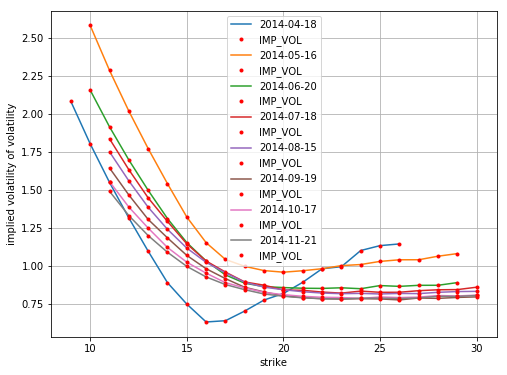

In [47]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
for maturity in maturies:
    data = plot_data[options_data.MATURITY==maturity]
    plt.plot(data['STRIKE'], data['IMP_VOL'], label=maturity.date(), lw=1.5
            )
    plt.plot(data['STRIKE'], data['IMP_VOL'], 'r.')
plt.grid(True)
plt.xlabel('strike')
plt.ylabel('implied volatility of volatility')
plt.legend()
plt.show()

在股票或外汇市场中，你将注意到所谓的隐含波动率微笑，而且到期日越短，隐含波动率微笑越明显；到期日越长，越不明显。

# 2. 期权定价的蒙特卡罗模拟  
蒙特卡罗是金融学和数值科学中最重要的算法之一。它之所以重要，是因为在期权定价或者风险管理问题上有很强的能力。  
和其他数值方法相比，蒙特卡罗方法很容易处理高维问题，在这种问题上复杂度和计算需求通常以线性方式增大。一下例子阐述了python的基于蒙特卡罗模拟的欧式期权估值方法。   

**公式 2-1** Black-Scholes-Merton随机微分方程  
$$dS_t=rS_tdt+\sigma S_tdZ_t$$
Z是一个布朗运动。  

**公式 2-2** SDE的欧拉离散
$$S_t=S_{t-\Delta_t}\ exp\lgroup \lgroup r -\frac{1}{2}\sigma^2\rgroup \Delta t+\sigma \sqrt{\Delta t}z_t\rgroup$$  
变量Z是标准正态分布随机变量，$0<\Delta_t<T$，是一个足够小的时间间隔。  
以S0=100、K=105、T=1.0、r=0.05、$\sigma$=0.2参数化上述模型，利用前面例子中的计算公式，可以得到精确的期权价值：

In [48]:
S0 = 100
K = 105
T = 1.0
r = 0.05
sigma = 0.2
bsm_call_value(S0, K, T, r, sigma)

8.021352235143176

**蒙特卡罗算法流程：**  
1. 将时间间隔 [0,T] 分为等距的、长度为$\Delta_t$的子时段。  
2. 开始循环 $i=1,2,\cdots, l。$  
 a) 对于每个时间步$t\in \{\Delta_t, 2\Delta_t,\dots, T \}$，取伪随机数 Z_t(i)。    
 b) 逐个时间步应用伪随机数，确定指数水平$S_T(i)$的T值，以离散化公式2-2的方案  
 c) 确定T时点欧式看涨期权的内在价值：$h_t:h_t(ST(i))=max(ST(i)-K, 0)$  
 d) 循环到 $i=I$  
3. 根据公式2-3，加总内在价值，求平均值，并扣除无风险短期利率。  
公式 2-3 欧式看涨期权的蒙特卡罗估算函数：  
$$C_0\approx e^{-rT}\frac{1}{I}\sum_Ih_T(S_T(i))$$

## 2.1 基础纯python版

In [58]:

from time import time
from math import exp, sqrt, log
from random import gauss, seed
seed(20000)
t0 = time()
# 参数设定
S0 = 100.
K = 105.
T = 1.
r = 0.05
sigma = 0.2
M = 50 # 时间步长
dt = T / M
I = 250000
S = []

# M步循环
for i in range(I):
    path = []
    for t in range(M+1):
        if t == 0 :
            path.append(S0)
        else:
            z = gauss(0, 1)
            St = path[t-1] * exp((r - 0.5 * sigma **2) * dt 
                                + sigma * sqrt(dt) * z)
            path.append(St)
    S.append(path)
C0 = exp(-r * T) * sum([max(path[-1] - K, 0) for path in S])/ I
print(f'欧式期权定价 {C0}.')
print(f'共计花费时间 {np.round(time()-t0,1) }s.')

欧式期权定价 7.9990448881765825.
共计花费时间 19.3s.


## 2.2 Numpy 向量化版本
Numpy 的优势
- 更紧凑的实现，减少代码冗余，往往更容易维护。
- 大部分Numpy是用C或者Fortran实现的，正确使用时，比纯python更快

In [61]:
#示例：使用Numpy的欧式看涨期权蒙特卡罗估值
import math
import numpy as np
np.random.seed(20000)
t0 = time()
# 参数
S0 = 100; K=105; T=1.; r=0.05; sigma=0.2
M=50; dt=T/M; I=250000
S = np.zeros((M+1, I))
S[0] = S0
for t in range(1, M+1):
    z = np.random.standard_normal(I)
    S[t] = S[t-1] * np.exp((r - 0.5 *sigma**2)*dt
                          + sigma * math.sqrt(dt) * z)
C0 = math.exp(-r*T) * np.sum(np.maximum(S[-1]-K, 0)) /I
print(f'欧式期权定价 {C0}.')
print(f'共计花费时间 {np.round(time()-t0,1) }s.')

欧式期权定价 8.03650296250933.
共计花费时间 0.7s.


向量化和纯Python 相比，速度有30倍以上的提升。且估算的蒙特卡罗值和基准值很接近。在对2-2公式进行对数化处理后，我们可以获得更高的效率。  
公式2-4 SDE的欧拉离散化方法（对数版本）
$$logS_T=logS_{T-\Delta_t}+(r-(1/2)\sigma^2)\Delta_t + \sigma\sqrt{\Delta_t}z_t$$
这个版本完全采用递增法，可以在Python层面上不使用任何循环的情况下实现蒙特卡罗算法。

In [71]:
#示例：
import math
import numpy as np
np.random.seed(20000)
t0 = time()
# 参数
S0 = 100; K=105; T=1.; r=0.05; sigma=0.2
S = S0 * np.exp(np.cumsum((r-0.5*sigma**2)*dt + sigma * math.sqrt(dt)
                       * np.random.standard_normal((M+1, I)), axis=0
                      ))
S[0] = S0
C0 = math.exp(-r*T) * np.sum(np.maximum(S[-1]-K, 0))/I

print(f'欧式期权定价 {C0}.')
print(f'共计花费时间 {np.round(time()-t0,1) }s.')

欧式期权定价 8.165807966259603.
共计花费时间 0.7s.


Text(0,0.5,'index level')

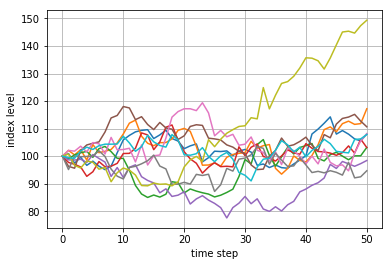

In [72]:
# 路径可视化
import matplotlib.pyplot as plt
plt.plot(S[:, : 10])
plt.grid(True)
plt.xlabel('time step')
plt.ylabel('index level')

Text(0,0.5,'frequency')

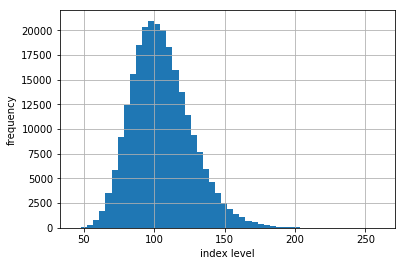

In [73]:
plt.hist(S[-1], bins=50)
plt.grid(True)
plt.xlabel('index level')
plt.ylabel('frequency')